## Assignment
Yeah ! Let's start with our actual project. In this assignment we will load the database and do preprocessing tasks.
Ensure you have following packages installed
1. numpy
2. pandas  
( Hope you are familiar with above two modules well )
3. nltk (don't worry, we just need this to remove stopwords while preprocessing)
4. tensorflow
5. keras
6. scikit-learn

In [1]:
'''
Importing essential libraries and functions
'''
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import io
import json
from nltk.tokenize import word_tokenize

## 1. Loading the IMDB Reviews Dataset

In [2]:
# TODO:
df=pd.read_csv('C:\\Users\\DELL\\Downloads\\IMDB_Dataset.csv')

In [3]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [4]:
df.shape
# 50000 rows and 2 columns

(50000, 2)

In [5]:
df.isnull().sum()
# no missing data

review       0
sentiment    0
dtype: int64

## 2. Data Preprocessing

In [6]:
#TODO : Complete the function to preprocess the text data

def preprocessing(sentence):
    sentence=sentence.lower() # First make the sentence lowercase
    sentence=re.sub(r'<[^>]+>',' ',sentence) # Remove all html tags from the sentence i.e replace anything between <> with space
    sentence=re.sub(r'[^a-zA-Z0-9]',' ',sentence)     # Remove all special characters i.e. anything other than alphabets and numbers. Replace them with space
    sentence=re.sub(r'\b[a-zA-Z]\b',' ',sentence) # Remove all single characters i.e. a-z and A-Z and Replace them with space
    sentence=re.sub(r'\s+',' ',sentence) # Remove all multiple spaces and replace them with single space
    # Use the nltk library to remove all stopwords from the sentence
    stop_words = set(stopwords.words('english'))
    sentence = word_tokenize(sentence)
    filtered_words = [i for i in sentence if i.lower() not in stop_words]
    cleaned_sentence = ' '.join(filtered_words)
    return cleaned_sentence

In [7]:
print(preprocessing('SAHIL IS A <****> BOY !?!'))

sahil boy


In [8]:
# TODO :
# Call the preprocessing function for each review in the dataframe and
# save the results in a new list of preprocessed_reviews
preprocessed_reviews=[]
for i in range(0,df.shape[0]):
    list=df['review'].tolist()
    text=list[i]
    text=preprocessing(text)
    preprocessed_reviews.append(text)
    
# This list will be your input to the neural network
# We will call this list as X from now on
X=preprocessed_reviews

In [9]:
# TODO :

df['sentiment']=df['sentiment'].replace({'positive':1,'negative':0})# Convert sentiment column in the dataframe to numbers
y=np.array(df['sentiment'])# Convert positive to 1 and negative to 0 and store it in numpy array
y=y.reshape(50000,1)
# We will call this numpy array as y from now on

In [10]:
# TODO : Split the data into training and testing (80-20 ratio)
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2)
# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

In [11]:
Y_train_=Y_train.reshape(40000,)

## Preparing embedding layer
Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning model like LSTM**.  
To know more about word embedding you may refer to following video
https://www.youtube.com/watch?v=9S0-OC4LFNo  
#### Tokenize the data

In [12]:
# Initialize the tokenizer
word_tokenizer = Tokenizer()

# TODO: Fit the tokenizer on the training data (X_train)
word_tokenizer.fit_on_texts(X_train)

# TODO: Convert training data to sequences of integers
# Hint: Use texts_to_sequences method
X_train_sequences = word_tokenizer.texts_to_sequences(X_train)

# TODO: Convert test data to sequences of integers
X_test_sequences = word_tokenizer.texts_to_sequences(X_test)
# Hint: Use texts_to_sequences method

# End TODO
# Saving the tokenizer in a json file (Already done for you)
# This will be used later for prediction on data in next assignments
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    
# Vocab_length is the number of unique words in our dataset
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92169

#### Padding

In [63]:
# Padding all reviews to be of same length 'maxlen' words
maxlen = 100
# You can try different dimensions like 50, 100, 200 and 300
# and see how the model performs in next week

# TODO: Pad the training data sequences
X_train_pad=pad_sequences(X_train_sequences,padding='post',maxlen=100)
# Hint: Use pad_sequences with 'post' padding and maxlen=maxlen

# TODO: Pad the test data sequences
X_test_pad=pad_sequences(X_test_sequences,padding='post',maxlen=100)
# Hint: Use pad_sequences with 'post' padding and maxlen=maxlen

#### Glove Embedding

In [14]:
# Initialize an empty dictionary for embeddings
embeddings_dictionary = dict()

# Open the GloVe file (a2_glove.6B.100d.txt) with utf-8 encoding
glove_file = open('C:\\Users\\DELL\\Desktop\\Sentiment Analysis_Soc\\glove_embeddings.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# TODO : Create an embedding matrix where each row corresponds to the index of the unique word in the dataset and each column corresponds to the word vector in the GloVe embedding So the matrix will have vocab_length rows and maxlen columns
vocab_size = len(word_tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [15]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38251001,  0.14821   ,  0.60601002, ...,  0.058921  ,
         0.091112  ,  0.47283   ],
       [ 0.19915999, -0.049702  ,  0.24579   , ..., -0.068109  ,
         0.017651  ,  0.06455   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.47060001,  0.77127999,  0.053355  , ...,  0.65398002,
         0.13931   ,  0.75156999]])

In [16]:
embedding_matrix.shape

(92169, 100)

In [17]:
import tensorflow as tf
from tensorflow import keras 
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Embedding,BatchNormalization, Dropout
from keras.optimizers import Adam

In [18]:
vocab_size = len(word_tokenizer.word_index) + 1
embedding_dim = 100
input_length = 100  # maxlen

In [44]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=input_length, 
                    trainable=False))

model.add(LSTM(30))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(50,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


In [38]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │       9,216,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,216,900 (35.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,216,900 (35.16 MB)

In [46]:
# Cool we have 9.2M non-trainable parameters
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
history=model.fit(X_train_pad,Y_train,validation_split=0.2,epochs=10,batch_size=100)

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.5315 - loss: 0.8501 - val_accuracy: 0.6335 - val_loss: 0.6855
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7631 - loss: 0.5091 - val_accuracy: 0.7749 - val_loss: 0.4560
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8161 - loss: 0.4144 - val_accuracy: 0.8120 - val_loss: 0.4246
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.8343 - loss: 0.3788 - val_accuracy: 0.7979 - val_loss: 0.4277
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8424 - loss: 0.3621 - val_accuracy: 0.8572 - val_loss: 0.3343
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8528 - loss: 0.3459 - val_accuracy: 0.8551 - val_loss: 0.3328
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.8586 - loss: 0.3330 - val_accuracy: 0.8530 - val_loss: 0.3453
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8652 - loss: 0.3181 - 

# GRAPHS

> Loss vs Valdiation loss

In [49]:
import matplotlib.pyplot as plt

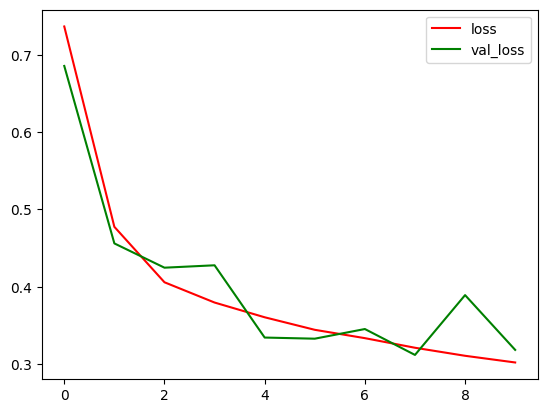

In [55]:
plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='g')
plt.legend(['loss','val_loss'])
# the model is not overfitting 

> Accuracy vs val_accuracy

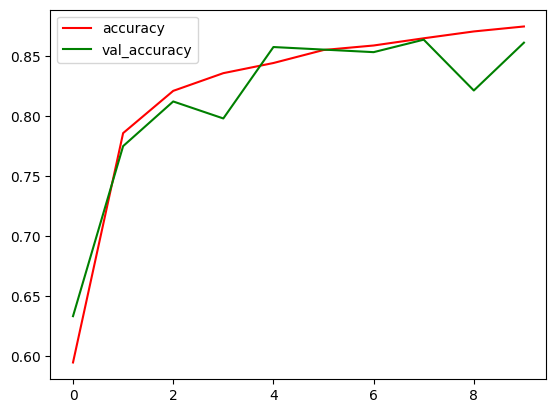

In [57]:
plt.plot(history.history['accuracy'],color='r')
plt.plot(history.history['val_accuracy'],color='g')
plt.legend(['accuracy','val_accuracy'])
# the model is not overfitting 

# ACCURACY OF OUR MODEL

In [59]:
from sklearn.metrics import accuracy_score,f1_score

In [64]:
Y_pred=model.predict(X_test_pad)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [117]:
Y_pred_f=np.where(Y_pred>=0.33,1,0)
# because the output is probabilistic 

In [118]:
Y_pred_f

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [119]:
print(accuracy_score(Y_test,Y_pred_f))

0.8726


In [120]:
print(f1_score(Y_test,Y_pred_f))

0.871856769261718


# SAVING THE MODEL

In [122]:
model.save('SOC24.keras')